# 1 Introduction

This is my first project (out of five) of Udacity Data Analyst Nanodegree. In this project, I work on baseball data CSV files (Master,
Salary,Batting) from Sean Lahman [webpage](http://www.seanlahman.com/baseball-archive/statistics/).
## 1.1 Research question

* AIM: Identify Batting and biographical info characteristics for highest salary.

Applied Methods:

* Independent sample T-test
* AVNOVA Analysis
* Linear regression
* Effective visualization


## 1.2 Data

This database contains pitching, hitting, and fielding statistics for Major League Baseball from 1871 through 2014.  It includes data from
the two current leagues (American and National), the four other "major" leagues (American Association, Union Association, Players League, and
Federal League), and the National Association of 1871-1875.The database is comprised of the following main tables:

* MASTER - Player names, DOB, and biographical info
* Batting - batting statistics


The design follows these general principles.  Each player is assigned a unique number (playerID).  All of the information relating to that player
is tagged with his playerID.  The playerIDs are linked to names and birthdates in the MASTER table.



# 2 Data Analysis
## 2.1 Data manipulation 

In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [70]:
from ggplot import *
import pandas as pd
import numpy as np
import scipy.stats
import matplotlib.pyplot as plt
import statsmodels.api as sm
import seaborn as sns
from IPython.display import Image

In [13]:
# import the original data into ipython notebook
path="D:/study/nanodegree/P2/intro to data science/project/lahman-csv/"
Master=pd.read_csv(path+"Master.csv")
Salary=pd.read_csv(path+'Salaries.csv')
Batting=pd.read_csv(path+'Batting.csv')


In [14]:
'''
2. defined functions for checking the raw data
''' 
# checking the data
def glimpse(df):
    return df.head()
    
# checking the dimension of data
def check_size(df):
    return df.shape
    
# checking data type for each column
def check_type(df):
    return df.dtypes
    
# checking for the missing value for each column
def count_unmiss(df):
    return df.count()

# summary for the numeric columns
def summary(df):
    return df.describe()

# define a function for standarize numeric variable
def standard(column):
        std_column=(column-column.mean())/column.std(ddof=0)
        return std_column  

### 2.1.1 Screen out the highest salary in every year in each team for each league 

In [15]:
# groupby the salary data by year,league, team

Salary_g=Salary.groupby(['yearID','lgID','teamID'],as_index=False)
# filter out the maximum salary for each year in each league and each team
Salary_max_per_team=Salary_g['salary'].max()
# merge playerID into Salary_max_per_team
Salary_max_per_team1=pd.merge(Salary_max_per_team, Salary, left_on=['yearID','lgID','teamID','salary'], right_on=['yearID','lgID','teamID','salary'],how='inner')

Salary_max_per_team1.shape

(888, 5)

In [16]:
# screen out the unique playerID for highest salary
Salary_max_unique_player=Salary_max_per_team1.drop_duplicates(cols='playerID')
print Salary_max_unique_player.shape
print Salary_max_unique_player.head()

(355, 5)
   yearID lgID teamID   salary   playerID
0    1985   AL    BAL  1472819  murraed02
1    1985   AL    BOS  1075000  stanlbo01
2    1985   AL    CAL  1100000  decindo01
3    1985   AL    CHA  1242333   cruzju01
4    1985   AL    CLE  1100000  thornan01


C:\Users\Nancy\Anaconda\lib\site-packages\IPython\kernel\__main__.py:2: FutureWarning: the 'cols' keyword is deprecated, use 'subset' instead
  from IPython.kernel.zmq import kernelapp as app


In [17]:
#write the data out into csv for backup
Salary_max_per_team1.to_csv(path+'output/max_salary.csv')
Salary_max_unique_player.to_csv(path+'output/max_salary_person.csv')

355 players with highest salay in each team for each league every year.

### 2.1.2 Merge highest salary table with Master table

In [18]:
# merge maximum salary table and master table together, try to find any physical information is related to highest salary
salary_master=Salary_max_unique_player.merge(Master,on='playerID',how='left')
salary_master.shape


(355, 28)

In [19]:
# delete the variables with missing value and non_meaningful
salary_master1=salary_master.drop(['deathYear','deathMonth','deathDay','deathCountry','deathState','deathCity','nameFirst',
                                   'nameLast','nameGiven','birthYear','birthMonth','birthDay','birthCountry','birthState',
                                  'birthCity','debut','finalGame','retroID','bbrefID'], axis=1)
# write out this data for saving
salary_master1.to_csv(path +'output/max_salary_master.csv')


In [20]:
#checking the data after deletion
print salary_master1.shape
print ''
print check_type(salary_master1)


(355, 9)

yearID        int64
lgID         object
teamID       object
salary        int64
playerID     object
weight      float64
height      float64
bats         object
throws       object
dtype: object


In [21]:
salary_master_2=salary_master1[['yearID','lgID','teamID','playerID','salary','weight','height','bats','throws']]
salary_master_2.to_csv(path+'output/salary_master.csv')

### 2.1.3 Merge salary_master table with batting table

In [22]:
salary_bat_master=salary_master_2.merge(Batting,on=['playerID','yearID','teamID','lgID'],how='left')
salary_bat_master.shape

(355, 27)

In [23]:
# find the columns with missing value 
print count_unmiss(salary_bat_master)

yearID      355
lgID        355
teamID      355
playerID    355
salary      355
weight      355
height      355
bats        355
throws      355
stint       340
G           340
AB          316
R           316
H           316
2B          316
3B          316
HR          316
RBI         316
SB          316
CS          316
BB          316
SO          316
IBB         316
HBP         316
SH          316
SF          316
GIDP        316
dtype: int64


In [24]:
# remove the missing value from the data salary_bat_master
salary_bat_master1=salary_bat_master[salary_bat_master['R'].notnull()]
salary_bat_master1.to_csv(path+'/output/salary_bat_master.csv')


In [25]:
# subset the category variable with salary in a new table
salary_bat_master2=salary_bat_master1[['salary','bats','throws']]

In [27]:
# select the numeric variales from data
salary_bat_master3=salary_bat_master1.drop(['yearID','lgID','teamID','playerID','bats','throws','stint'],axis=1)
column=salary_bat_master3.columns

27 variables and 316 obesrevations are kept in the salary_bat_master1 data for following analysis. 

Variable list
* salary,         Player Salary
* playerID,       Player ID code
* yearID,         Year
* teamID,         Team
* lgID,           League
* weight,         Player's weight in pounds
* height,         Player's height in inches
* bats,           Player's batting hand (left, right, or both)         
* throws,         Player's throwing hand (left or right)
* G,              Games
* AB,             At Bats
* R,              Runs
* H,              Hits
* 2B,             Doubles
* 3B,             Triples
* HR,             Homeruns
* RBI,            Runs Batted In
* SB,             Stolen Bases
* CS,             Caught Stealing
* BB,             Base on Balls
* SO,             Strikeouts
* IBB,            Intentional walks
* HBP,            Hit by pitch
* SH,             Sacrifice hits
* SF,             Sacrifice flies
* GIDP,           Grounded into double plays

The following 19 scatter plots will show  each numeric variable with salary

## 2.2 Calculation Pearson's correlation coefficient for numeric variables with salary

Checking the dependent variable salary. From the plot below, salary is right skewed.

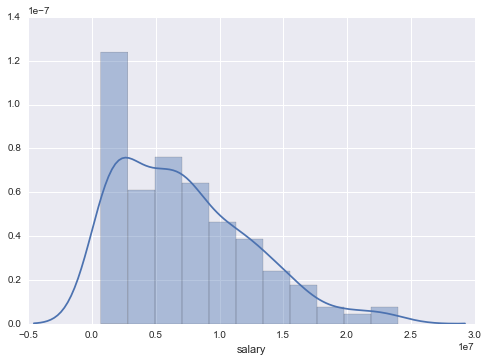

In [93]:
sns.distplot(salary_bat_master1.salary);

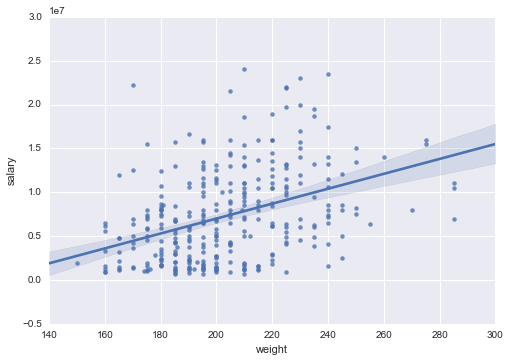

In [28]:
def plot(var):
    scat_plot=sns.regplot(x=var, y="salary", data=salary_bat_master3)
    return scat_plot

plot(column[1]);


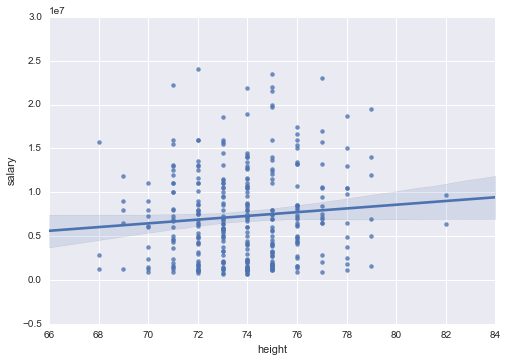

In [29]:
plot(column[2])

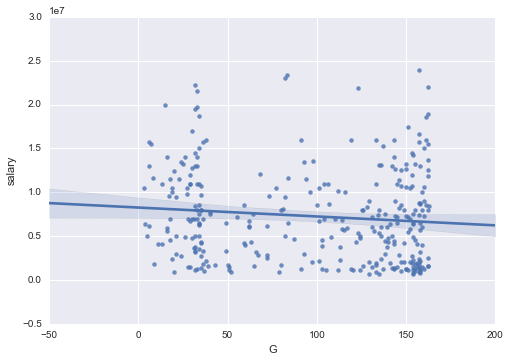

In [30]:
plot(column[3])

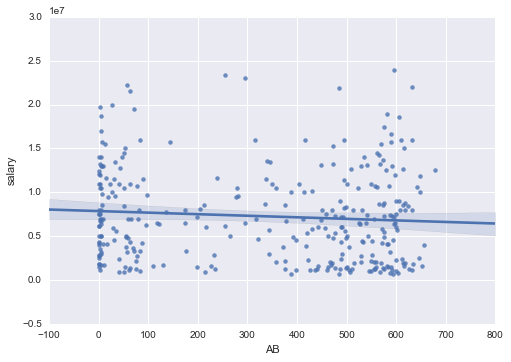

In [31]:
plot(column[4])

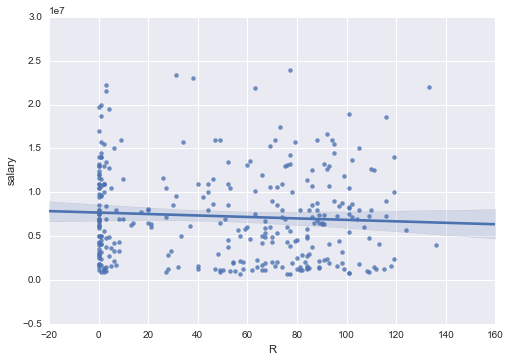

In [32]:
plot(column[5])

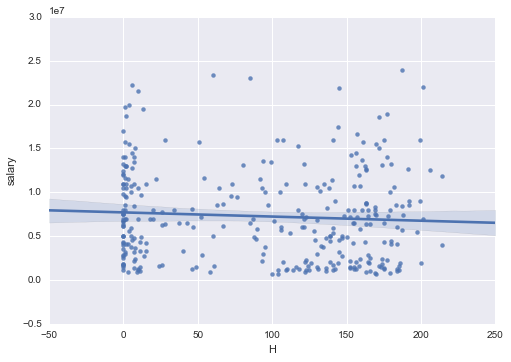

In [33]:
plot(column[6])

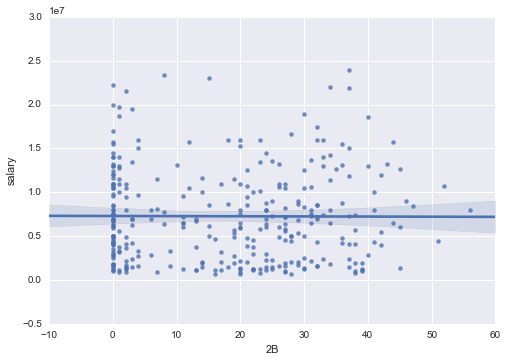

In [34]:
plot(column[7])

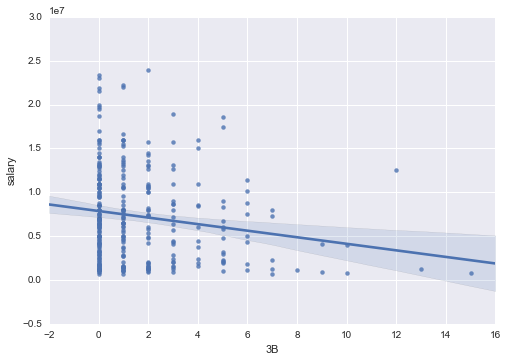

In [35]:
plot(column[8])

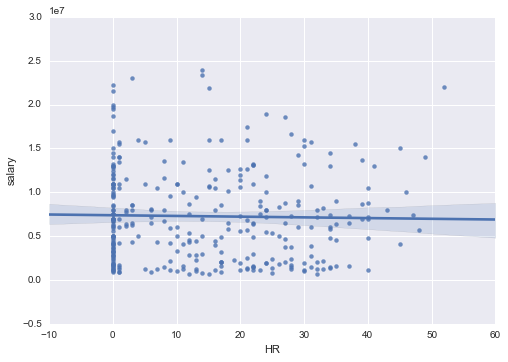

In [36]:
plot(column[9])

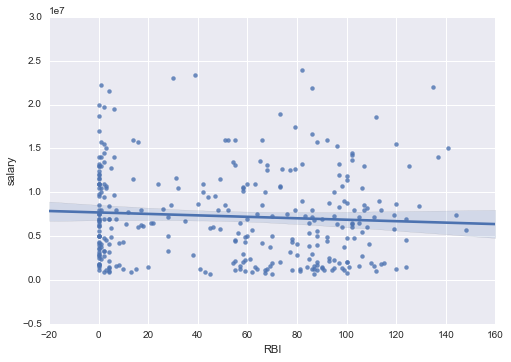

In [37]:
plot(column[10])

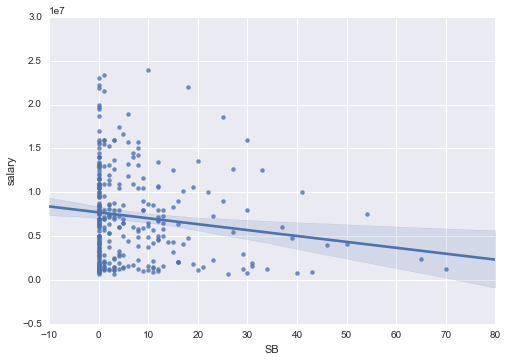

In [38]:
plot(column[11])

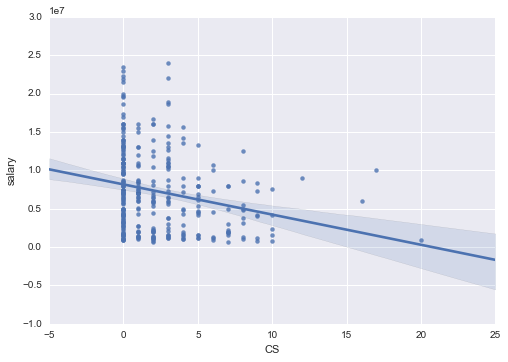

In [39]:
plot(column[12])

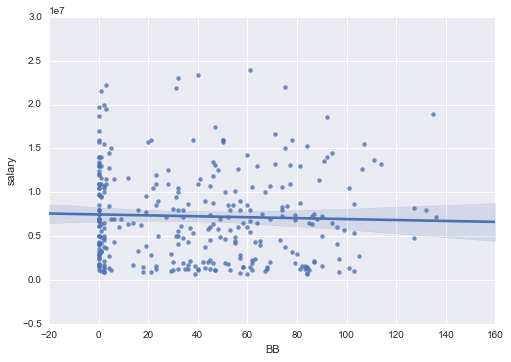

In [40]:
plot(column[13])

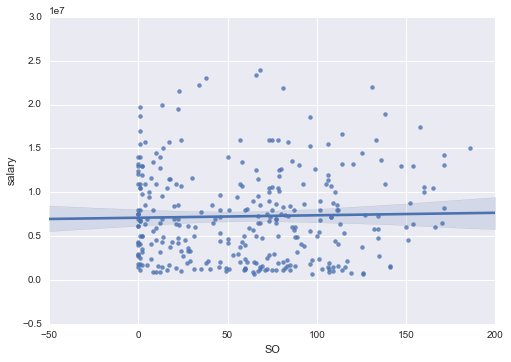

In [41]:
plot(column[14])

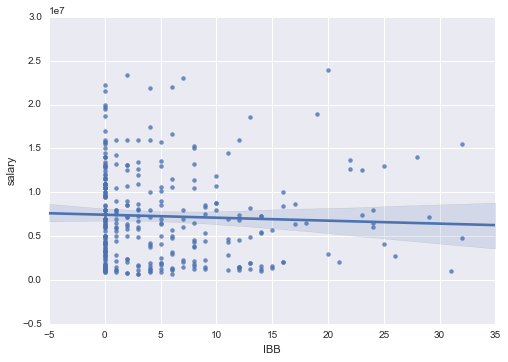

In [42]:
plot(column[15])

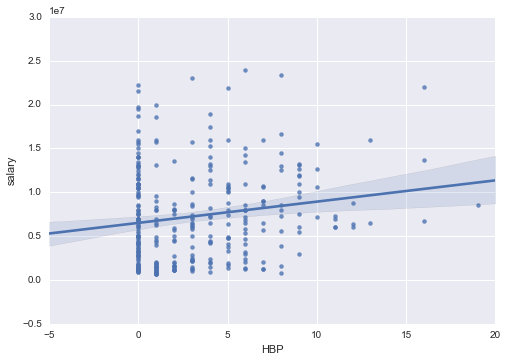

In [43]:
plot(column[16])

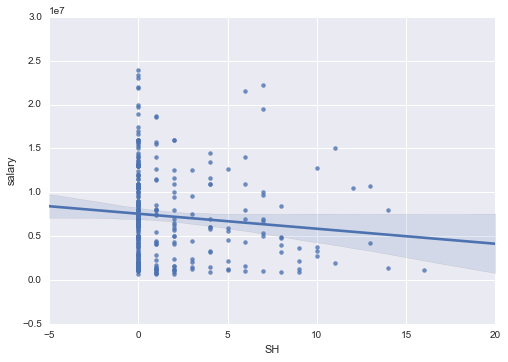

In [44]:
plot(column[17])

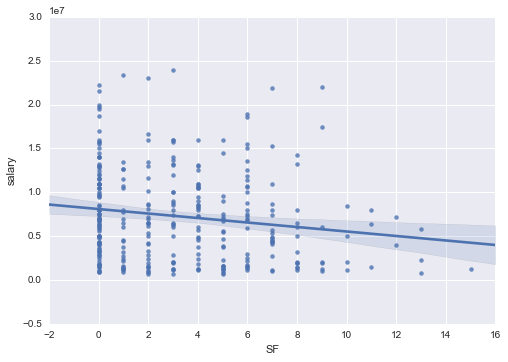

In [45]:
plot(column[18])

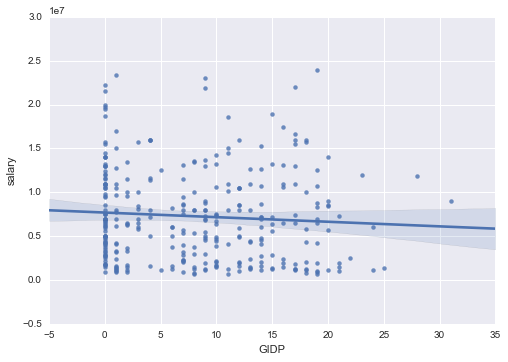

In [46]:
plot(column[19])

In [47]:
#calculated the pearson's correlation coefficient
correlation=salary_bat_master3.corr()
correlation[correlation.columns[0:1]]


,salary
salary,1.000000
weight,0.397563
height,0.093696
G,-0.105450
AB,-0.081131
R,-0.064467
H,-0.064673
2B,-0.004519
3B,-0.165332
HR,-0.021246


From scatter plots and correlation coefficient matrix, we can easily see non of them are strong correlated to salary.So we remove the irrelavant
variables.+(-)0.1 are adopted as a therohold to fitler out the variables. So wieght, G, 3B, SB, CS, HBP and SF are kept for the further analysis.

## 2.3 Categorical Variable Analysis

Boxplots will plot below.

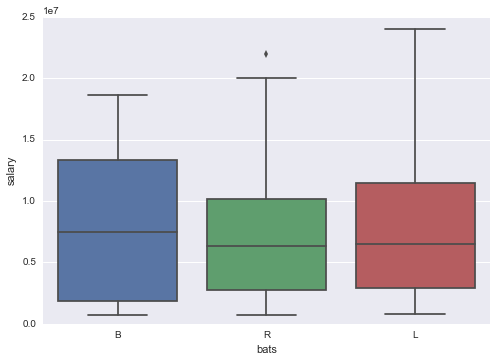

In [48]:
sns.boxplot(x="bats", y="salary", data=salary_bat_master2)

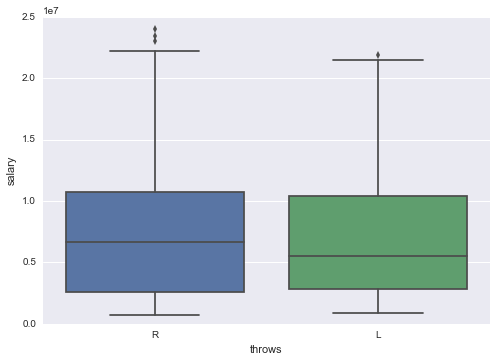

In [49]:
sns.boxplot(x="throws", y="salary", data=salary_bat_master2)

* The first boxplot show the mean of salary among player with left, right and both side hand batting.From this boxplot, we can 
  slightly see that player with both batting maybe pay more than those with left hand or right hand batting.

* The second boxplot show the mean of salary among player with left and right hand throwing.From the second plot, we can slightly see that player with right hand throwing maybe paye more than those with left hand throwing.



In order to verify the results from boxplots, independent T test and ANOVA will be uesd to compare the avarage salary between different groups.

In [50]:
salary_throw_R=salary_bat_master2[salary_bat_master2.throws=='R']
salary_throw_L=salary_bat_master2[salary_bat_master2.throws=='L']
salary_bat_L=salary_bat_master2[salary_bat_master2.bats=='L']
salary_bat_R=salary_bat_master2[salary_bat_master2.bats=='R']
salary_bat_B=salary_bat_master2[salary_bat_master2.bats=='B']
#ttest
print scipy.stats.ttest_ind(salary_throw_R['salary'], salary_throw_L['salary'])
print ''
#one way anova
print scipy.stats.f_oneway(salary_bat_L['salary'],salary_bat_R['salary'],salary_bat_B['salary'])

Ttest_indResult(statistic=0.29050723150582797, pvalue=0.77161999054258601)

F_onewayResult(statistic=1.3510059436878337, pvalue=0.2604855411693886)



* Independent T-test is employed for testing the different salary level for players with different throwing habits. The T statistics 
  is 0.2905 with P-value 0.7716,so we conclude that no difference between the avarage saraly for player with left and right hand throwing.
 

* One way ANOVA is employed for testing the different among the players with left, right or both batting habits.The F statistics is
  1.3510(df=2) with P-value 0.2604, so we conclude that no difference between the avarage saraly for player with differnt batting habits.
    
    
* From analysis above, bats and throws do not impact player's salary. So them are excluded from the final analysis.

## 2.4 Linear Regression

### 2.4.1  Checking the collinearity of explanatory matrix
From the analysis result, 7 variables related to the salary are kept for the linear regression.

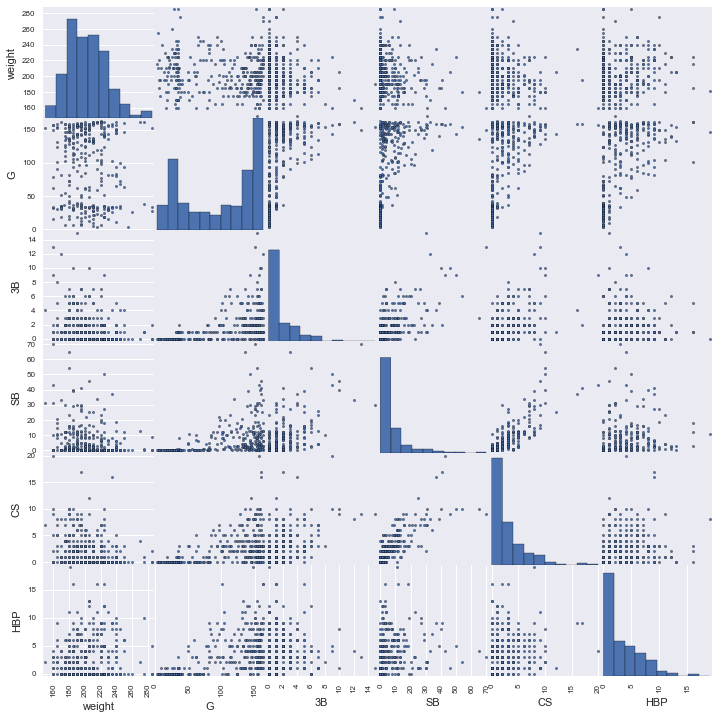

In [51]:
#correlation coefficient plot matrix
salary_bat_master4=salary_bat_master3[['salary','weight','G','3B','SB','CS','HBP','SF']]
a = pd.scatter_matrix(salary_bat_master4[salary_bat_master4.columns[1:7]],alpha=1,figsize=(12,12), diagonal='hist')

In [52]:
#correlation coefficient matrix for explanatory variables
correlation1=salary_bat_master4[salary_bat_master4.columns[1:7]].corr()
correlation1

,weight,G,3B,SB,CS,HBP
weight,1.000000,-0.090321,-0.219259,-0.204591,-0.247741,0.089803
G,-0.090321,1.000000,0.522415,0.464053,0.537103,0.585073
3B,-0.219259,0.522415,1.000000,0.650116,0.580333,0.185506
SB,-0.204591,0.464053,0.650116,1.000000,0.815269,0.245923
CS,-0.247741,0.537103,0.580333,0.815269,1.000000,0.288899
HBP,0.089803,0.585073,0.185506,0.245923,0.288899,1.000000


In [53]:
# eigen values of explanatory correlation coefficient matrix
w, v = np.linalg.eig(correlation1)
v[:,0]


array([ 0.16372523, -0.44433246, -0.45158495, -0.4907413 , -0.49784195,
       -0.28837495])

The scatter matrices of different combinations of the possible explanatory variables to check whether any two variables are not 
correlated. From the plot G 3B,SB,CS and HBP are highly correlated to each other, and the correlation coefficient matrix shows the same result.So eigen vector of correlation coefficient matrix is calculated. -0.44433246, -0.45158495, -0.4907413 and -0.49784195 are eigen values for 3B,SB,CS,HBP respectively, and these give the same reuslt. So we can remove G,3B and SB from the explanatory matrix.


In [54]:
salary_bat_master5=salary_bat_master4.drop(['G','SB','3B'],axis=1)
# correlation matrix for new explanatory variables
salary_bat_master5.corr()

,salary,weight,CS,HBP,SF
salary,1.000000,0.397563,-0.230891,0.166307,-0.156970
weight,0.397563,1.000000,-0.247741,0.089803,-0.097315
CS,-0.230891,-0.247741,1.000000,0.288899,0.357472
HBP,0.166307,0.089803,0.288899,1.000000,0.387890
SF,-0.156970,-0.097315,0.357472,0.387890,1.000000


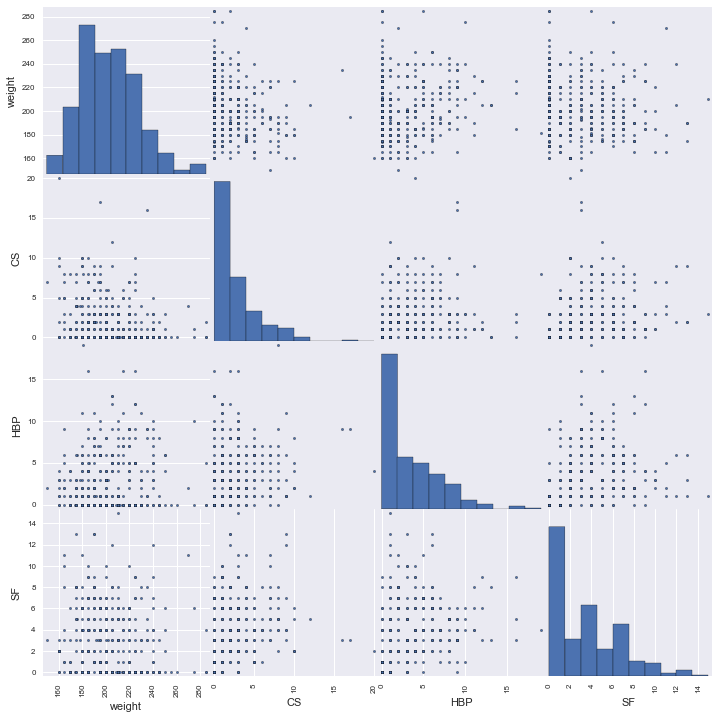

In [55]:
# scatter plot for each pairwise explanaroty variables
b=pd.scatter_matrix(salary_bat_master5[salary_bat_master5.columns[1:]],alpha=1,figsize=(12,12), diagonal='hist')

The correlation coefficient matrix and the graph above show that no strong correlation between pairwise explanatory variables  in the final model.

### 2.4.2 Normalized numeric variables

Normalized all the numerical variables reduce the magnitude of different variables for regression.

In [56]:
salary_bat_master5['salary_nor']=standard(salary_bat_master5.salary)
salary_bat_master5['weight_nor']=standard(salary_bat_master5.weight)
salary_bat_master5['cs_nor']=standard(salary_bat_master5.CS)
salary_bat_master5['HBP_nor']=standard(salary_bat_master5.HBP)
salary_bat_master5['SF_nor']=standard(salary_bat_master5.SF)

In [57]:
salary_bat_master5.columns
salary_bat_master6=salary_bat_master5[['salary_nor','weight_nor', 'cs_nor', 'HBP_nor', 'SF_nor']]

In [58]:
from patsy import dmatrices
y, X = dmatrices('salary_nor ~ weight_nor + cs_nor + HBP_nor + SF_nor', 
                 data=salary_bat_master6, return_type='dataframe')
X.head()

,Intercept,weight_nor,cs_nor,HBP_nor,SF_nor
0,1,-0.540542,-0.096198,-0.313251,1.498998
2,1,-0.540542,0.557537,-0.313251,1.186129
3,1,-1.566311,0.884404,-0.313251,-0.691084
4,1,-0.130234,-0.096198,-0.872501,0.873260
5,1,-0.130234,0.557537,-0.592876,-0.378215


### 2.4.3 The First Model

In [65]:
from statsmodels.formula.api import ols

In [71]:
model = ols(formula='salary_nor ~ weight_nor + cs_nor + HBP_nor + SF_nor', data=salary_bat_master5)
fitted = model.fit()
print fitted.summary()

                            OLS Regression Results                            
Dep. Variable:             salary_nor   R-squared:                       0.232
Model:                            OLS   Adj. R-squared:                  0.222
Method:                 Least Squares   F-statistic:                     23.46
Date:                Thu, 03 Mar 2016   Prob (F-statistic):           5.75e-17
Time:                        11:19:12   Log-Likelihood:                -406.72
No. Observations:                 316   AIC:                             823.4
Df Residuals:                     311   BIC:                             842.2
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
Intercept  -8.674e-18      0.050  -1.75e-16      1.0

The first linear regression result show that the R<sup>2</sup> is 0.232. I am not surprised about the result.Because we just examined Master and Batting
factors impacting on highest salary, there are almost 20 tables storing other information mabybe having contribution on salary. If we can contain
all the important information, the R<sup>2</sup> will become larger. In this analysis, P-values for weight, CS,HBP,SF are 0.000,0.003, 0.000,0.004 
respectively, and they significantly impact on salary. But the intercept is nearly 0 and with p-value 1. I will do the data diagonostic analysis for
this model, and try to find out whether other reasons will impact model fitted.

#### 2.4.3.1 Regression Diagnostics

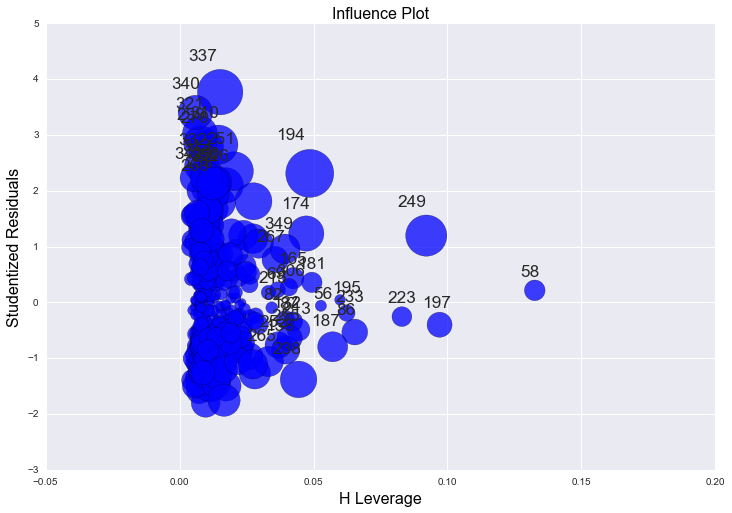

In [73]:
fig, ax = plt.subplots(figsize=(12,8))
fig = sm.graphics.influence_plot(fitted, ax=ax, criterion="cooks")

From the influence Plot, 58 observation apart from other observations, but its h leverage is just around 0.14. So none of observations is
highly influence for the model. 

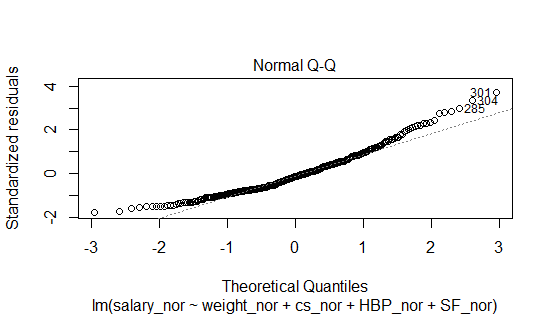

In [82]:
Image(filename='C:/Users/Nancy/Desktop/figure/Rplot.png')

In [ ]:
The above plot is used R to generate. From the plot, we can see the residuals are not normally distributed. So cox-box transformation
will be used on dependent variable here.

### 2.4.4 The second model

Cox_Box transformation is used on dependent variable salary.

In [88]:
xt, _ = scipy.stats.boxcox(salary_bat_master5['salary'])
salary_bat_master5['trans_salary']=xt

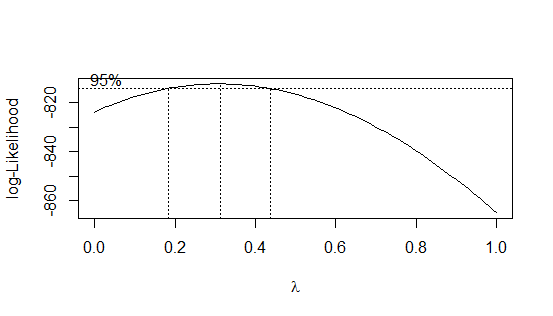

In [92]:
Image(filename='C:/Users/Nancy/Desktop/figure/Rplot03.png')

From the log-likelihood graph above, we can see the log-likelihood was maximized when λ=0.315.So I decided to fit another linear 
regression model with the all the same explanatory variables but Box-Cox transformed dependent variable of λ=0.315

In [90]:
model1 = ols(formula='trans_salary ~ weight_nor + cs_nor + HBP_nor + SF_nor', data=salary_bat_master5)
fitted1 = model1.fit()
print fitted1.summary()

                            OLS Regression Results                            
Dep. Variable:           trans_salary   R-squared:                       0.257
Model:                            OLS   Adj. R-squared:                  0.248
Method:                 Least Squares   F-statistic:                     26.95
Date:                Thu, 03 Mar 2016   Prob (F-statistic):           3.26e-19
Time:                        13:00:26   Log-Likelihood:                -1900.1
No. Observations:                 316   AIC:                             3810.
Df Residuals:                     311   BIC:                             3829.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
Intercept    437.6552      5.608     78.042      0.0

The second linear regression result show that the R<sup>2</sup> is 0.257. After transformation it increased a little. In this analysis, P-values 
for weight, CS,HBP,SF are 0.000,0.002, 0.000,0.001 respectively, and they significantly impact on salary. Nad the t statistics of intercept is 78.042 0 
and with p-value 0. 

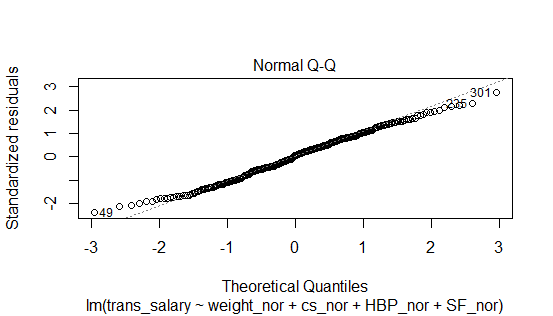

In [94]:
Image(filename='C:/Users/Nancy/Desktop/figure/Rplot05.png')

In [ ]:
Then I examined the QQ plot for standardized residuals again. Although the residuals are much better than before.

# 3 Conclusion

From the analysis above,  4 variables in Master and Batting table are significantly related to highest salary. Weight and 
HBP(Hit by pitch) are positive with salary level, but CS(Caught Stealing) and SF(Sacrifice flies) are negative with salary level.
Other variables in Master and batting table are not relative to the salary level.


# 4 Discussion

The above study are limited in two part:
    1.This analysis just show part of characteristic of baseball player associated with salary level. So R<sup>2</sup> is so samll.
      If we want to examine which other variables are related to salary level, we have to analyze the rest of tables.
    2.Since I am not a professional in baseball area, some important information maybe were removed from dataset. 